Prepare paired images from lookbook images

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color
from skimage.transform import resize
from skimage.util import pad, img_as_ubyte
import util.lookbook_pair as lookbook_pair

import argparse

In [3]:
class Options():
    def __init__(self):
        self.initialized = False
        
    def initialize(self, parser):
        parser.add_argument('--job_name', required=True, help='name of job, result of job will put into {target_folder}/{job_name}')
        
        parser.add_argument('--n_train', type=int, default=400, help='number of product in training set')
        parser.add_argument('--n_test', type=int, default=100, help='number of product in test set')
        parser.add_argument('--n_pair', type=int, default=1, help='# how many pair (maximum) for each product')
    
        parser.add_argument('--src_folder', type=str, default='c:/ml/lookbook/', help='folder of lookbook images')
        parser.add_argument('--target_folder', type=str, default='c:/ml/lookbook_paired/', help='parent folder of lookbook pairs images')
    
        parser.add_argument('--image_size', type=int, default=256, help='default paired image size is 512 * 256')
        
        parser.add_argument('-f', default='', type=str, help='placeholder for notebook')
        self.initialized = True
        return parser
    
    def gather_options(self, args):
        if not self.initialized:
            parser = argparse.ArgumentParser(formatter_class=argparse.ArgumentDefaultsHelpFormatter)
            parser = self.initialize(parser)
        
        # save and return the parser
        self.parser = parser
        return parser.parse_args(args)
        
    def print_options(self, opt):
        message = ''
        message += '----------------- Options ---------------\n'
        for k, v in sorted(vars(opt).items()):
            comment = ''
            default = self.parser.get_default(k)
            if v != default:
                comment = '\t[default: %s]' % str(default)
            message += '{:>25}: {:<30}{}\n'.format(str(k), str(v), comment)
        message += '----------------- End -------------------'
        print(message)

    def parse(self, args=None):
        opt = self.gather_options(args)
        
        opt.job_target_folder = opt.target_folder + opt.job_name + '/'

        self.print_options(opt)

        self.opt = opt
        return self.opt

opt = Options().parse(['--job_name', 'test1', '--n_train', '3', '--n_test', '2', '--n_pair', '2'])
    

----------------- Options ---------------
                        f:                               
               image_size: 256                           
                 job_name: test1                         	[default: None]
        job_target_folder: c:/ml/lookbook_paired/test1/  	[default: None]
                   n_pair: 2                             	[default: 1]
                   n_test: 2                             	[default: 100]
                  n_train: 3                             	[default: 400]
               src_folder: c:/ml/lookbook/               
            target_folder: c:/ml/lookbook_paired/        
----------------- End -------------------


In [4]:
def create_target_path(opt):
    image_path = opt.job_target_folder + 'image/'
    if not os.path.exists(image_path):
        os.makedirs(image_path)    
        
    sub_path = image_path + 'train/'
    if not os.path.exists(sub_path):
        os.mkdir(sub_path)

    sub_path = image_path + 'test/'
    if not os.path.exists(sub_path):
        os.mkdir(sub_path)
        
        
# create target path
create_target_path(opt)

In [5]:
def get_lookbook_files(opt):
    '''
    return file names in lookbook
    '''
    image_path = opt.src_folder + 'data/'
    
    files = [f for f in os.listdir(image_path) if f.endswith('.jpg')]
    return files

r = get_lookbook_files(opt)
print(len(r), r[:5])

77546 ['PID000000_CLEAN0_IID000000.jpg', 'PID000000_CLEAN0_IID000001.jpg', 'PID000000_CLEAN0_IID000002.jpg', 'PID000000_CLEAN0_IID000003.jpg', 'PID000000_CLEAN0_IID000004.jpg']


In [6]:
# a trial of regular expression
p = re.compile(r'PID(?P<product_id>\d{6})_CLEAN(?P<is_product>\d)_IID(?P<image_id>\d{6})')
m = p.match('PID000012_CLEAN0_IID000020.jpg')
if m:
    print(m.groupdict())

{'product_id': '000012', 'is_product': '0', 'image_id': '000020'}


In [7]:
# a trial of dictionary
d = {}
l = ['a', 'a', 'a', 'b', 'b', 'c']

for c in l:
    if c in d:
        d[c] += 1
    else:
        d[c] = 1
        
for k, v in d.items():
    print(k, v)

a 3
b 2
c 1


In [8]:
def read_lookbook(files):
    '''
    read files of lookbook images and return the look book structure
    Image file name: sprintf( 'PID%06d_CLEAN%d_IID%06d', product_id, is_product_image, image_id )
    
    files : a list of string
    returns:
        a dictionary of 
        {'product_id': '000012', 
         'product_image': 'PID000000_CLEAN1_IID000011',
         'model_images': ['PID000000_CLEAN0_IID000000', ......]}
    
    '''
    # a regex to get info from file name
    p = re.compile(r'PID(?P<product_id>\d{6})_CLEAN(?P<is_product>\d)_IID(?P<image_id>\d{6})')
    
    # a dictionary of products
    dic = {}
    
    for f in files:
        m = p.match(f)
        if m:
            fi = m.groupdict()  # fi is like {'product_id': '000012', 'is_product': '0', 'image_id': '000020'}
            if not (fi['product_id'] in dic):
                dic[fi['product_id']] = {'product_id': fi['product_id'], 
                                         'product_image': None, 
                                         'model_images': []}
            product = dic[fi['product_id']]
            if fi['is_product'] == '1':
                product['product_image'] = f
            else:
                product['model_images'].append(f)
                
    return dic
            
files = get_lookbook_files(opt)    
dic = read_lookbook(files[:50])
dic

{'000000': {'product_id': '000000',
  'product_image': 'PID000000_CLEAN1_IID000011.jpg',
  'model_images': ['PID000000_CLEAN0_IID000000.jpg',
   'PID000000_CLEAN0_IID000001.jpg',
   'PID000000_CLEAN0_IID000002.jpg',
   'PID000000_CLEAN0_IID000003.jpg',
   'PID000000_CLEAN0_IID000004.jpg',
   'PID000000_CLEAN0_IID000005.jpg',
   'PID000000_CLEAN0_IID000006.jpg',
   'PID000000_CLEAN0_IID000007.jpg',
   'PID000000_CLEAN0_IID000008.jpg',
   'PID000000_CLEAN0_IID000009.jpg',
   'PID000000_CLEAN0_IID000010.jpg']},
 '000001': {'product_id': '000001',
  'product_image': 'PID000001_CLEAN1_IID000029.jpg',
  'model_images': ['PID000001_CLEAN0_IID000012.jpg',
   'PID000001_CLEAN0_IID000013.jpg',
   'PID000001_CLEAN0_IID000014.jpg',
   'PID000001_CLEAN0_IID000015.jpg',
   'PID000001_CLEAN0_IID000016.jpg',
   'PID000001_CLEAN0_IID000017.jpg',
   'PID000001_CLEAN0_IID000018.jpg',
   'PID000001_CLEAN0_IID000019.jpg',
   'PID000001_CLEAN0_IID000020.jpg',
   'PID000001_CLEAN0_IID000021.jpg',
   'PID0000

In [9]:
# explore look book
files = get_lookbook_files(opt)    
dic = read_lookbook(files)
lst = list(dic.values())

n_total_product = n_total_model = n_missed_product = n_max_model = 0
n_min_model = 99999

for product in lst:
    n_total_product += 1
    c = len(product['model_images'])
    n_total_model += c
    if product['product_image'] is None:
        n_missed_product += 1
    if c > n_max_model:
        n_max_model = c
    if c < n_min_model:
        n_min_model = c
        
print('total', n_total_product, n_total_model)
print('missed product', n_missed_product)
print('model', n_min_model, n_total_model // n_total_product, n_max_model)
    

total 8726 68820
missed product 0
model 1 7 55


In [10]:
# try permutation
perm = np.random.permutation(len(lst))
for idx in perm[:5]:
    product = lst[idx]
    print(product)


{'product_id': '001641', 'product_image': 'PID001641_CLEAN1_IID019426.jpg', 'model_images': ['PID001641_CLEAN0_IID019418.jpg', 'PID001641_CLEAN0_IID019419.jpg', 'PID001641_CLEAN0_IID019420.jpg', 'PID001641_CLEAN0_IID019421.jpg', 'PID001641_CLEAN0_IID019422.jpg', 'PID001641_CLEAN0_IID019423.jpg', 'PID001641_CLEAN0_IID019424.jpg', 'PID001641_CLEAN0_IID019425.jpg']}
{'product_id': '001361', 'product_image': 'PID001361_CLEAN1_IID015976.jpg', 'model_images': ['PID001361_CLEAN0_IID015958.jpg', 'PID001361_CLEAN0_IID015959.jpg', 'PID001361_CLEAN0_IID015960.jpg', 'PID001361_CLEAN0_IID015961.jpg', 'PID001361_CLEAN0_IID015962.jpg', 'PID001361_CLEAN0_IID015963.jpg', 'PID001361_CLEAN0_IID015964.jpg', 'PID001361_CLEAN0_IID015965.jpg', 'PID001361_CLEAN0_IID015966.jpg', 'PID001361_CLEAN0_IID015967.jpg', 'PID001361_CLEAN0_IID015968.jpg', 'PID001361_CLEAN0_IID015969.jpg', 'PID001361_CLEAN0_IID015970.jpg', 'PID001361_CLEAN0_IID015971.jpg', 'PID001361_CLEAN0_IID015972.jpg', 'PID001361_CLEAN0_IID015973.jpg

In [11]:
def select_model(l_product, product_indices, n_pair):
    '''
    select model from product
    
    l_product: list of product
    product_indices: selected products index
    n_pair: number of model per product
    
    returns:
    list of (product_file, model_file)
    '''
    r = []
    
    for idx in product_indices:
        product = l_product[idx]
        models = product['model_images']
        model_perm = np.random.permutation(len(models))
        for model_idx in model_perm[:min(len(models), n_pair)]:
            r.append((product['product_image'], models[model_idx]))
            
    return r

files = get_lookbook_files(opt)    
dic = read_lookbook(files)
lst = list(dic.values())
select_model(lst, [0, 2], 2)

[('PID000000_CLEAN1_IID000011.jpg', 'PID000000_CLEAN0_IID000002.jpg'),
 ('PID000000_CLEAN1_IID000011.jpg', 'PID000000_CLEAN0_IID000004.jpg'),
 ('PID000002_CLEAN1_IID000048.jpg', 'PID000002_CLEAN0_IID000039.jpg'),
 ('PID000002_CLEAN1_IID000048.jpg', 'PID000002_CLEAN0_IID000040.jpg')]

In [12]:
def pair_files(dic_product, n_train, n_test, n_pair):
    '''
    pair product file name with model's
    
    dic_product: a dictionary of 
        {'product_id': '000012', 
         'product_image': 'PID000000_CLEAN1_IID000011',
         'model_images': ['PID000000_CLEAN0_IID000000', ......]}
    n_train: number of product to select for train set
    n_test: number of product to select for test set
    
    returns:
    l_train: list of (product_file, model_file), note that the length may be less than n_pair * n_train
    l_test: list of (product_file, model_file)
    '''
    l_product = list(dic_product.values())
    product_perm = np.random.permutation(len(l_product))
    
    l_train = select_model(l_product, product_perm[:n_train], n_pair)
    l_test = select_model(l_product, product_perm[n_train:n_train + n_test], n_pair)
    
    return l_train, l_test

files = get_lookbook_files(opt)    
dic = read_lookbook(files)
pair_files(dic, 2, 1, 1)

([('PID001344_CLEAN1_IID015698.jpg', 'PID001344_CLEAN0_IID015685.jpg'),
  ('PID001154_CLEAN1_IID013248.jpg', 'PID001154_CLEAN0_IID013237.jpg')],
 [('PID007968_CLEAN1_IID069094.jpg', 'PID007968_CLEAN0_IID069080.jpg')])

In [13]:
def combine_file_name(product, model):
    '''
    generate paired file name, in format like PID000292_CLEAN1_IID004184_IID004176.jpg
    
    product: file name of product, like PID000292_CLEAN1_IID004184.jpg
    model: file name of model, like PID000292_CLEAN0_IID004176.jpg
    
    returns: 
        file name of combined, like PID000292_CLEAN1_IID004184_IID004176.jpg
    '''
    last = len(product)
    return product[:last-4] + model[last-14:]

combine_file_name('PID000292_CLEAN1_IID004184.jpg', 'PID000292_CLEAN0_IID004176.jpg')

'PID000292_CLEAN1_IID004184_IID004176.jpg'

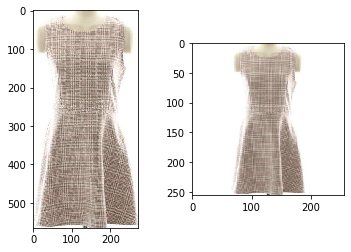

In [14]:
def resize_and_padding(image, desired_size = 64):
    """
    resize image to desired size
    keep it's ratio by padding it
    
    Arguments:
        image -- the image to resize
        desired_size -- the desire size of image, scalar
    
    Returns:
        the resized and padded image
    """
    old_size = image.shape[:2]  # old_size[0] is in (width, height) format

    ratio = float(desired_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])

    image_resized = resize(image, new_size, anti_aliasing=True)
    
    padding_top = (desired_size - new_size[0]) // 2
    padding_bottom = desired_size - new_size[0] - padding_top
    padding_left = (desired_size - new_size[1]) // 2
    padding_right = desired_size - new_size[1] - padding_left

    #if np.sum(image_resized >= 245.0/255.0) / image_resized.size > 0.65: 
    #    # most of the image is white
    image_padded = pad(image_resized, [(padding_top, padding_bottom), \
                                    (padding_left, padding_right), \
                                    (0, 0)], mode='constant', constant_values=1)
    #else:
    #    image_padded = pad(image_resized, [(padding_top, padding_bottom), \
    #                                   (padding_left, padding_right), \
    #                                    (0, 0)], mode='edge')
    
    assert(image_padded.shape[0] == desired_size)
    assert(image_padded.shape[1] == desired_size)
    return img_as_ubyte(image_padded)

plt.subplot(1, 2, 1)
img = io.imread(opt.src_folder + 'data/PID000292_CLEAN1_IID004184.jpg')
plt.imshow(img)

plt.subplot(1, 2, 2)
img_converted = resize_and_padding(img, 256)
plt.imshow(img_converted)

plt.show()

In [15]:
def fix_channel(image):
    """
    fix number of channels to 3
    
    Arguments:
        image -- image to be processed
        
    Returns:
        fixed image
    """
    if len(image.shape) == 2:  # 1 channel image
        image_rgb = color.gray2rgb(image)
        return image_rgb
    elif len(image.shape) == 3 and image.shape[2] == 4:  # 4 channels image ie png
        image_reduced = image[:, :, :3]
        return image_reduced
    elif len(image.shape) == 3 and image.shape[2] == 3:  # normla image
        return image
    else:
        assert(False)

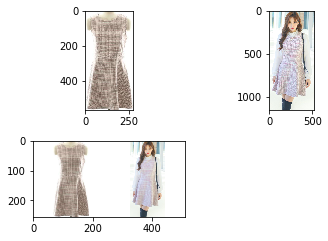

In [16]:
def stack_images(img1, img2):
    '''
    stack 2 image in same size horizontally
    
    img1: image in np array
    img2: image in np array
    
    returns:
        image in np array
    '''
    assert(img1.shape == img2.shape)
    img = np.hstack([img1, img2])
    return img

plt.subplot(2, 2, 1)
img1 = io.imread(opt.src_folder + 'data/PID000292_CLEAN1_IID004184.jpg')
plt.imshow(img1)
img1 = resize_and_padding(img1, 256)


plt.subplot(2, 2, 2)
img2 = io.imread(opt.src_folder + 'data/PID000292_CLEAN0_IID004176.jpg')
plt.imshow(img2)
img2 = resize_and_padding(img2, 256)

plt.subplot(2, 2, 3)
img = stack_images(img1, img2)
plt.imshow(img)

plt.show()

In [17]:
def generate_paired(opt):
    '''
    read lookbook images, select some of them, generate paired images and save
    
    opt : Options
    
    returns:
        None
    '''
    create_target_path(opt)
    
    # pair files
    files = get_lookbook_files(opt)
    dic_product = read_lookbook(files)
    train_pairs, test_pairs = pair_files(dic_product, opt.n_train, opt.n_test, opt.n_pair)
    
    # combine images
    for pairs, division in [(train_pairs, 'train'), (test_pairs, 'test')]:
        src_path = opt.src_folder + 'data/'
        target_path = opt.job_target_folder + 'image/' + division + '/'
        for product, model in pairs:
            img_product = io.imread(src_path + product)
            img_product = fix_channel(img_product)
            img_product = resize_and_padding(img_product, opt.image_size)
            
            img_model = io.imread(src_path + model)
            img_model = fix_channel(img_model)
            img_model = resize_and_padding(img_model, opt.image_size)
            
            img = stack_images(img_product, img_model)
            file = target_path + combine_file_name(product, model)
            io.imsave(file, img)


opt_test = Options().parse(['--job_name', 'test2', '--n_train', '3', '--n_test', '2', '--n_pair', '2'])
generate_paired(opt_test)


----------------- Options ---------------
                        f:                               
               image_size: 256                           
                 job_name: test2                         	[default: None]
        job_target_folder: c:/ml/lookbook_paired/test2/  	[default: None]
                   n_pair: 2                             	[default: 1]
                   n_test: 2                             	[default: 100]
                  n_train: 3                             	[default: 400]
               src_folder: c:/ml/lookbook/               
            target_folder: c:/ml/lookbook_paired/        
----------------- End -------------------


In [22]:
! python util/lookbook_pair.py --job_name test3 --n_train 2 --n_test 1

----------------- Options ---------------
                        f:                               
               image_size: 256                           
                 job_name: test3                         	[default: None]
        job_target_folder: c:/ml/lookbook_paired/test3/  	[default: None]
                   n_pair: 1                             
                   n_test: 1                             	[default: 100]
                  n_train: 2                             	[default: 400]
               src_folder: c:/ml/lookbook/               
            target_folder: c:/ml/lookbook_paired/        
----------------- End -------------------
